In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
import numpy as np

import plotly.graph_objects  as go

from sklearn.metrics import mean_absolute_error as _mae, mean_absolute_percentage_error as _mape, classification_report

import os
import re 
from tqdm import tqdm 

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('../catboost classifier/dataset_final.csv')

c:\Users\maksk\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df = df[
    (df['salary_from_rate_and_gross'] > 13_500) 
        &
    (df['salary_from_rate_and_gross'] < 230_000) 
]

In [4]:
stop_words = stopwords.words('russian')
vectorizer = TfidfVectorizer(max_features=300, stop_words=stop_words, min_df=100)
tfidf_array = np.array(vectorizer.fit_transform(df['description_clear_lemm']).todense(), dtype=np.float32)
tfidf_array = np.delete(tfidf_array, [0, 1, 2, 3, 5, 7, 8, 9], 1)
columns = np.delete(vectorizer.get_feature_names_out(), [0, 1, 2, 3, 5, 7, 8, 9])

In [5]:
tfidf_features = []
for i in range(len(columns)):
    df.loc[:, 'description_tfidf_' + columns[i]] = tfidf_array[:, i]
    tfidf_features.append('description_tfidf_' + columns[i])

<AxesSubplot:>

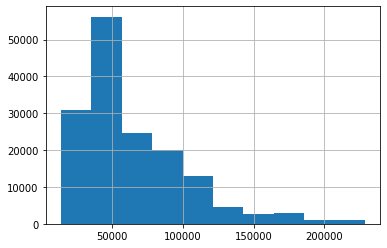

In [6]:
df['salary_from_rate_and_gross'].hist()

In [7]:
buckets = list(np.arange(-1, 250_000+10_000, 10_000)) + [np.inf]
buckets = pd.DataFrame(np.vstack([buckets[:-1], buckets[1:]])).T.values

In [8]:
for bucket in buckets:
    df.loc[
        (df['salary_from_rate_and_gross'] > bucket[0])
            &
        (df['salary_from_rate_and_gross'] <= bucket[1])
    , 'label'] = f'[{bucket[0]}, {bucket[1]})'

In [9]:
df[['uniq_skills_cnt', 'uniq_popular_skills_cnt']] = df[['uniq_skills_cnt', 'uniq_popular_skills_cnt']].fillna(0)

In [10]:
features = {
    'features': [
        'billing_type',
        'schedule',
        'name',
        'area',
        'allow_messages',
        'experience',
        'accept_handicapped',
        'accept_kids',
        'employer',
        'accept_temporary',
        '15',
        'lat',
        'lng',
        'department_name',
        'has_department',
        # 'description_clear',
        'description_len',
        'uniq_skills_cnt',
        'uniq_popular_skills_cnt',
        'professional_roles_id',
        'dollar_rate',
        'is_engl',
        'is_ger',
        'is_chi',
        'cnt_lang',
        'label',
    ],
    'cat_features': [
        'billing_type',
        'schedule',
        'area',
        'experience',
        'employer',
        '15',
        'department_name',
        'professional_roles_id'
    ],
    'text_features': [
        'name',
        # 'description_clear'
    ]
}
features['features'] += ['mean_similar', 'min_similar', 'max_similar', 'feature_290', 'feature_370'] 
features['features'] += tfidf_features

In [11]:
def pool(data, label, cat_features, text_features):
    return Pool(
        data=data,
        label=label,
        cat_features=cat_features,
        text_features=text_features,
    )

def train(df:pd.DataFrame, features:dict, device='GPU'):
    cat_features = features['cat_features']
    text_features = features['text_features']
    features = features['features']
    X_train, X_valid, y_train, y_valid = train_test_split(df[features].drop(['label'], axis=1), df['label'], test_size=0.3, random_state=0, stratify=df['label'])
    X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=0, stratify=y_valid)

    pools = {}
    print(X_train.shape)
    pools['train'] = pool(X_train, y_train, cat_features, text_features)
    pools['valid'] = pool(X_valid, y_valid, cat_features, text_features)
    pools['test'] = pool(X_test, y_test, cat_features, text_features)
    model = CatBoostClassifier(iterations = 1_500, task_type=device)
    model.fit(
        pools['train'],
        eval_set=pools['valid'],
        use_best_model=True,
        plot=False,
        verbose=50,
        early_stopping_rounds=50,
    )
    datasets = {
        'train': [X_train, y_train],
        'valid': [X_valid, y_valid],
        'test': [X_test, y_test]
    }
    y_pred = model.predict(pools['test'])
    cr = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred, output_dict=False))
    return model, pools, datasets, cr

In [12]:
model, pools, datasets, cr = train(df, features)

(109936, 321)
Learning rate set to 0.141591
0:	learn: 2.6188896	test: 2.6138561	best: 2.6138561 (0)	total: 118ms	remaining: 2m 56s
50:	learn: 1.6166910	test: 1.6061658	best: 1.6061658 (50)	total: 4.88s	remaining: 2m 18s
100:	learn: 1.5489329	test: 1.5512903	best: 1.5512903 (100)	total: 8.95s	remaining: 2m 4s
150:	learn: 1.5062606	test: 1.5214661	best: 1.5214661 (150)	total: 13s	remaining: 1m 56s
200:	learn: 1.4756552	test: 1.5040454	best: 1.5040454 (200)	total: 17s	remaining: 1m 49s
250:	learn: 1.4491589	test: 1.4899449	best: 1.4899449 (250)	total: 21s	remaining: 1m 44s
300:	learn: 1.4263486	test: 1.4804087	best: 1.4804087 (300)	total: 25.1s	remaining: 1m 39s
350:	learn: 1.4045736	test: 1.4721467	best: 1.4721467 (350)	total: 29.1s	remaining: 1m 35s
400:	learn: 1.3850996	test: 1.4642377	best: 1.4642377 (400)	total: 33.1s	remaining: 1m 30s
450:	learn: 1.3659331	test: 1.4578734	best: 1.4578734 (450)	total: 37.1s	remaining: 1m 26s
500:	learn: 1.3474748	test: 1.4517232	best: 1.4516688 (499)

In [117]:
df.loc[137543, model.feature_names_]

billing_type                                 Стандарт
schedule                                  Полный день
name                              Финансовый менеджер
area                                           Москва
allow_messages                                   True
                                         ...         
description_tfidf_человек                         0.0
description_tfidf_эксплуатация                    0.0
description_tfidf_это                             0.0
description_tfidf_являться                        0.0
description_tfidf_язык                            0.0
Name: 137543, Length: 321, dtype: object

In [119]:
df.loc[137543, model.feature_names_].to_excel('delete2.xlsx', index=False)

In [114]:
model.predict(pools['test'])

array([['[109999.0, 119999.0)'],
       ['[39999.0, 49999.0)'],
       ['[69999.0, 79999.0)'],
       ...,
       ['[109999.0, 119999.0)'],
       ['[109999.0, 119999.0)'],
       ['[49999.0, 59999.0)']], dtype=object)

In [120]:
df.iloc[0]

item_id                                                                74293318
company_vacancies_url             https://api.hh.ru/vacancies?employer_id=18068
item_url                                         https://hh.ru/vacancy/74293318
has_premium                                                                   0
billing_type                                                           Стандарт
                                                      ...                      
description_tfidf_человек                                                   0.0
description_tfidf_эксплуатация                                              0.0
description_tfidf_это                                                       0.0
description_tfidf_являться                                                  0.0
description_tfidf_язык                                                      0.0
Name: 0, Length: 421, dtype: object

In [115]:
datasets['test'][0]

billing_type        schedule  \
137543       Стандарт     Полный день   
105370       Стандарт     Полный день   
82114        Стандарт     Полный день   
2505         Стандарт     Полный день   
106277       Стандарт  Вахтовый метод   
...               ...             ...   
106825       Стандарт  Сменный график   
96599   Стандарт плюс     Полный день   
130427       Стандарт  Вахтовый метод   
22401        Стандарт     Полный день   
23254        Стандарт     Полный день   

                                                     name  \
137543                                Финансовый менеджер   
105370                                               Швея   
82114                 Супервайзер торговых представителей   
2505                                Помощник руководителя   
106277                 Стропальщик (с функциями грузчика)   
...                                                   ...   
106825                                           Наборщик   
96599   Заведующий/Начальник лаборатории (молочное про...   
130427                                         Мастер ПРР   
22401                      Руководитель отдела маркетинга   
23254                                         Оператор ПК   

                       area  allow_messages          experience  \
137543               Москва            True       От 3 до 6 лет   
105370         Екатеринбург            True           Нет опыта   
82114                Тамбов            True  От 1 года до 3 лет   
2505           Екатеринбург            True           Нет опыта   
106277  Николаевск-на-Амуре            True  От 1 года до 3 лет   
...                     ...             ...                 ...   
106825      Санкт-Петербург            True  От 1 года до 3 лет   
96599          Долгопрудный            True  От 1 года до 3 лет   
130427               Самара            True       От 3 до 6 лет   
22401                Москва            True  От 1 года до 3 лет   
23254              Красково            True  От 1 года до 3 лет   

        accept_handicapped  accept_kids  \
137543               False        False   
105370               False        False   
82114                False        False   
2505                 False        False   
106277               False        False   
...                    ...          ...   
106825               False        False   
96599                False        False   
130427               False        False   
22401                False        False   
23254                False        False   

                                                 employer  accept_temporary  \
137543  ано учебно-методический центр военно-патриотич...             False   
105370                                               stan             False   
82114                                           вертикаль             False   
2505                           лавелина татьяна вадимовна             False   
106277                                        амур золото             False   
...                                                   ...               ...   
106825                                     компания ixora             False   
96599                                         айскейк-эко             False   
130427                                          универсал             False   
22401                                        13 by timati             False   
23254                                         авто-альянс             False   

        ... description_tfidf_хотеть  description_tfidf_цель  \
137543  ...                      0.0                0.109378   
105370  ...                      0.0                0.000000   
82114   ...                      0.0                0.177501   
2505    ...                      0.0                0.000000   
106277  ...                      0.0                0.000000   
...     ...                      ...                     ...   
106825  ...                      0.0                0.000000   


In [107]:
# model.save_model('../app/model/base2.cbm')

In [97]:
pd.DataFrame({
    'feature_name': model.feature_names_,
    'feature_importance': model.feature_importances_
}).sort_values(by='feature_importance', ascending=False)

feature_name  feature_importance
24    mean_similar           17.220907
2             name           13.741116
25     min_similar            4.377951
8         employer            3.334579
26     max_similar            3.227055
..             ...                 ...
23        cnt_lang            0.003196
7      accept_kids            0.000210
22          is_chi            0.000000
21          is_ger            0.000000
14  has_department            0.000000

[321 rows x 2 columns]

In [14]:
import shap
import catboost
explainer = shap.KernelExplainer(model.predict_proba, datasets['train'])

Using 109936 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [26]:
cat_features = features['cat_features']
text_features = features['text_features']
features = features['features']
X_train, X_valid, y_train, y_valid = train_test_split(df[features].drop(['label'], axis=1), df['label'], test_size=0.3, random_state=0, stratify=df['label'])
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=0, stratify=y_valid)

pools = {}
pools['train'] = pool(X_train.head(1000), y_train.head(1000), cat_features, text_features)
pools['valid'] = pool(X_valid, y_valid, cat_features, text_features)
pools['test'] = pool(X_test, y_test, cat_features, text_features)

In [27]:
shap_values = model.get_feature_importance(pools['train'], type=catboost.EFstrType.ShapValues)

In [28]:
shap_values.shape

(1000, 22, 322)

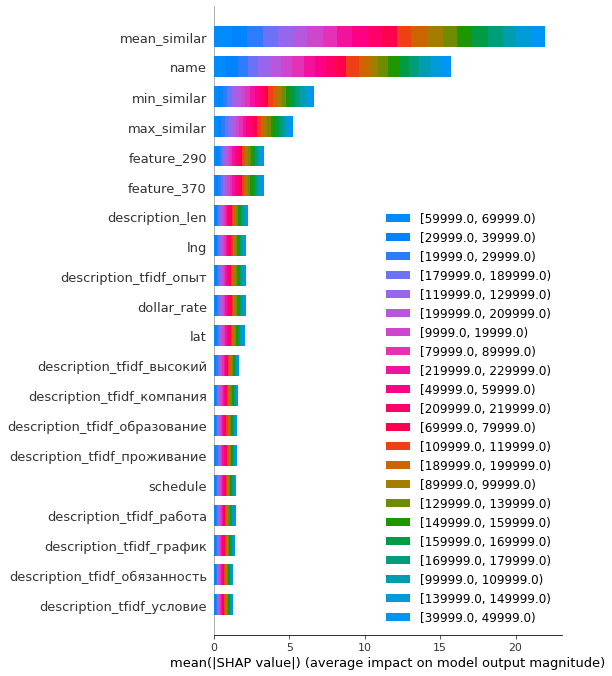

In [29]:
original_shape = shap_values.shape
shap_values_reshaped = shap_values.reshape(original_shape[1], original_shape[0], original_shape[-1])
shap.summary_plot(list(shap_values_reshaped[:,:,:-1]), features=datasets['train'], class_names=model.classes_, plot_type='bar')

In [14]:
import shap
import joblib
shap.initjs()

explainer = shap.TreeExplainer(model)

ex_filename = '../app/explainer2.bz2'
joblib.dump(explainer, filename=ex_filename, compress=('bz2', 9))

['../app/explainer2.bz2']

# DecisionTree

In [30]:
features = {
    'features': [
        'billing_type',
        'schedule',
        'name',
        'area',
        'allow_messages',
        'experience',
        'accept_handicapped',
        'accept_kids',
        'employer',
        'accept_temporary',
        '15',
        'lat',
        'lng',
        'department_name',
        'has_department',
        # 'description_clear',
        'description_len',
        'uniq_skills_cnt',
        'uniq_popular_skills_cnt',
        'professional_roles_id',
        'dollar_rate',
        'is_engl',
        'is_ger',
        'is_chi',
        'cnt_lang',
        'label',
    ],
    'cat_features': [
        'billing_type',
        'schedule',
        'area',
        'experience',
        'employer',
        '15',
        'department_name',
        'professional_roles_id'
    ],
    'text_features': [
        'name',
        # 'description_clear'
    ]
}
features['features'] += ['mean_similar', 'min_similar', 'max_similar', 'feature_290', 'feature_370'] 
features['features'] += tfidf_features

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(df[features['features']].drop(['label'], axis=1), df['label'], test_size=0.3, random_state=0, stratify=df['label'])
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=0, stratify=y_valid)

In [32]:
X_train.drop(features['text_features'], axis=1, inplace=True)
X_valid.drop(features['text_features'], axis=1, inplace=True)
X_test.drop(features['text_features'], axis=1, inplace=True)

In [33]:
encoder = preprocessing.OrdinalEncoder()
encoder.set_params(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(X_train[features['cat_features']])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [34]:
X_train[features['cat_features']] = encoder.transform(X_train[features['cat_features']])
X_valid[features['cat_features']] = encoder.transform(X_valid[features['cat_features']])
X_test[features['cat_features']] = encoder.transform(X_test[features['cat_features']])

In [35]:
X_train = X_train.fillna(-1)
X_valid = X_valid.fillna(-1)
X_test = X_test.fillna(-1)

In [38]:
tree = DecisionTreeClassifier(max_depth=7)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7)

In [39]:
print(classification_report(y_test, tree.predict(X_test), output_dict=False))

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


                      precision    recall  f1-score   support

[109999.0, 119999.0)       0.29      0.29      0.29       998
[119999.0, 129999.0)       0.00      0.00      0.00       328
[129999.0, 139999.0)       0.19      0.39      0.26       425
[139999.0, 149999.0)       0.00      0.00      0.00       214
[149999.0, 159999.0)       0.00      0.00      0.00       201
[159999.0, 169999.0)       0.24      0.50      0.32       375
[169999.0, 179999.0)       0.00      0.00      0.00        28
[179999.0, 189999.0)       0.00      0.00      0.00        66
[189999.0, 199999.0)       0.00      0.00      0.00        56
  [19999.0, 29999.0)       0.65      0.32      0.42      1841
[199999.0, 209999.0)       0.00      0.00      0.00       111
[209999.0, 219999.0)       0.00      0.00      0.00        18
[219999.0, 229999.0)       0.23      0.44      0.30       131
  [29999.0, 39999.0)       0.38      0.69      0.49      3803
  [39999.0, 49999.0)       0.50      0.28      0.36      3226
  [4999

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


# RandomForest

In [40]:
tree = RandomForestClassifier(max_depth=15, n_estimators=100,)
tree.fit(X_train, y_train)

RandomForestClassifier(max_depth=15)

In [41]:
print(classification_report(y_test, tree.predict(X_test), output_dict=False))

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


                      precision    recall  f1-score   support

[109999.0, 119999.0)       0.32      0.43      0.36       998
[119999.0, 129999.0)       0.82      0.25      0.38       328
[129999.0, 139999.0)       0.72      0.21      0.33       425
[139999.0, 149999.0)       0.87      0.25      0.39       214
[149999.0, 159999.0)       0.85      0.16      0.28       201
[159999.0, 169999.0)       0.49      0.31      0.38       375
[169999.0, 179999.0)       1.00      0.14      0.25        28
[179999.0, 189999.0)       0.88      0.23      0.36        66
[189999.0, 199999.0)       1.00      0.45      0.62        56
  [19999.0, 29999.0)       0.64      0.31      0.42      1841
[199999.0, 209999.0)       1.00      0.28      0.44       111
[209999.0, 219999.0)       0.00      0.00      0.00        18
[219999.0, 229999.0)       0.97      0.23      0.37       131
  [29999.0, 39999.0)       0.44      0.76      0.56      3803
  [39999.0, 49999.0)       0.58      0.23      0.33      3226
  [4999

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [43]:
# EDA

In [46]:
df.columns.to_list()

['item_id',
 'company_vacancies_url',
 'item_url',
 'has_premium',
 'billing_type',
 'schedule',
 'name',
 'area',
 'salary_from',
 'salary_to',
 'salary_currency',
 'is_gross',
 'address',
 'allow_messages',
 'experience',
 'department',
 'contacts',
 'description',
 'key_skills_x',
 'accept_handicapped',
 'accept_kids',
 'specializations',
 'professional_roles',
 'employer',
 'published_at',
 'working_days',
 'working_time_intervals',
 'working_time_modes',
 'accept_temporary',
 'languages',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 'key_skills_y',
 'salary_log',
 'city',
 'lat',
 'lng',
 'line_embedding',
 'station_embedding',
 'department_name',
 'has_department',
 'description_clear',
 'description_len',
 'key_skills_embedding',
 'uniq_skills_cnt',
 'uniq_popular_skills_cnt',
 'professional_roles_id',
 'dollar_rate',
 'is_engl',
 'is_ger',
 'is_chi',
 'cnt_lang',
 'salary_from_rate_and_gross',
 'salary_from

Text(0.5, 1.0, 'Диаграмма рассеивания целевой переменной с has_department')

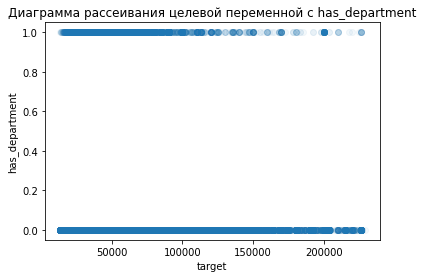

In [65]:
plt.scatter(df.salary_from_rate_and_gross, df.has_department, alpha=0.05)
plt.xlabel('target')
plt.ylabel('has_department')
plt.title('Диаграмма рассеивания целевой переменной с has_department')

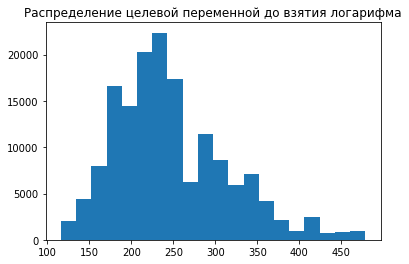

In [78]:
plt.hist(df.salary_from_rate_and_gross ** .5, bins=20);
plt.title('Распределение целевой переменной до взятия логарифма');

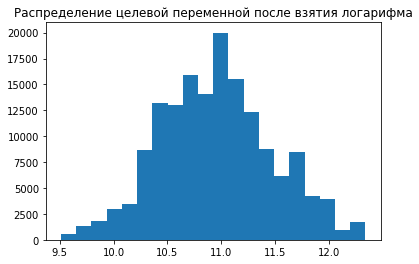

In [71]:
plt.hist(df.salary_from_rate_and_gross_log, bins=20);
plt.title('Распределение целевой переменной после взятия логарифма');

In [75]:
import math
import numpy as np
from scipy.stats import shapiro,kstest 
from scipy. stats import lognorm

shapiro(df.salary_from_rate_and_gross_log)

p-value may not be accurate for N > 5000.


ShapiroResult(statistic=0.9940724968910217, pvalue=0.0)

In [80]:
kstest(df.salary_from_rate_and_gross, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [84]:
import plotly.express as px
fig = px.box(df, x="experience", y="salary_from_rate_and_gross", title='Диаграмма размаха переменной experience')
fig.show()